# Heading

## Test

## Again

In [1]:
import json
import requests
import pandas as pd

In [2]:
url = "https://opendata.meteo.be/service/ows?service=WFS&version=2.0.0&request=GetCapabilities"
url = "https://opendata.meteo.be/service/ows?service=WFS&version=2.0.0&request=GetFeature&typenames=aws:aws_1hour&outputformat=json&CQL_FILTER=((BBOX(the_geom,3.201846,50.193663,5.255236,51.347375,%20%27EPSG:4326%27))%20AND%20(timestamp%20%3E=%20%272020-01-01%2000:00:00%27%20AND%20timestamp%20%3C=%20%272020-07-01%2000:00:00%27))&sortby=timestamp"

In [3]:
rep = requests.get(url)
#print(rep.content)

In [4]:
data = requests.get(url).json()

In [5]:
pdata = []
for rec in data["features"]:
    rec["properties"]["qc_flags"] = json.loads(rec["properties"]["qc_flags"])
    pdata.append(rec)

In [6]:
df = pd.json_normalize(pdata)

In [7]:
df = df.drop(["type", "geometry_name", "geometry.type", "properties.bbox"], axis=1)

In [8]:
df.head()

,id,geometry.coordinates,properties.code,properties.timestamp,properties.air_pressure,properties.air_temperature,properties.relative_humidity,properties.precipitation,properties.wind_speed,properties.qc_flags.pres_flag,properties.qc_flags.temp_flag,properties.qc_flags.hum_flag,properties.qc_flags.precip_flag,properties.qc_flags.wSpeed_flag
0,aws_1hour.6418.2020-01-01 04:00:00.0,"[3.2018, 51.3474]",6418,2020-01-01T04:00:00Z,1029,0,0,0,0,0,0,0,0,0
1,aws_1hour.6472.2020-01-01 05:00:00.0,"[5.2552, 50.1937]",6472,2020-01-01T05:00:00Z,996,0,0,0,0,0,0,0,0,0
2,aws_1hour.6418.2020-01-01 06:00:00.0,"[3.2018, 51.3474]",6418,2020-01-01T06:00:00Z,1030,3,98,0,4,0,0,0,0,0
3,aws_1hour.6472.2020-01-01 06:00:00.0,"[5.2552, 50.1937]",6472,2020-01-01T06:00:00Z,996,-1,97,0,3,0,0,0,0,0
4,aws_1hour.6418.2020-01-01 07:00:00.0,"[3.2018, 51.3474]",6418,2020-01-01T07:00:00Z,1030,3,97,0,4,0,0,0,0,0


In [9]:
keys = ["properties.code", "properties.timestamp", "geometry.coordinates"]

In [10]:
dr = df.filter(regex='geometry\.|properties\.')\
       .melt(id_vars=keys)

In [11]:
dr

,properties.code,properties.timestamp,geometry.coordinates,variable,value
0,6418,2020-01-01T04:00:00Z,"[3.2018, 51.3474]",properties.air_pressure,1029
1,6472,2020-01-01T05:00:00Z,"[5.2552, 50.1937]",properties.air_pressure,996
2,6418,2020-01-01T06:00:00Z,"[3.2018, 51.3474]",properties.air_pressure,1030
3,6472,2020-01-01T06:00:00Z,"[5.2552, 50.1937]",properties.air_pressure,996
4,6418,2020-01-01T07:00:00Z,"[3.2018, 51.3474]",properties.air_pressure,1030
...,...,...,...,...,...
87215,6472,2020-06-30T22:00:00Z,"[5.2552, 50.1937]",properties.qc_flags.wSpeed_flag,0
87216,6418,2020-06-30T23:00:00Z,"[3.2018, 51.3474]",properties.qc_flags.wSpeed_flag,0
87217,6472,2020-06-30T23:00:00Z,"[5.2552, 50.1937]",properties.qc_flags.wSpeed_flag,0
87218,6418,2020-07-01T00:00:00Z,"[3.2018, 51.3474]",properties.qc_flags.wSpeed_flag,0


In [12]:
coords = dr.pop("geometry.coordinates")
dr["geometry.lon"] = coords.apply(lambda x: x[0])
dr["geometry.lat"] = coords.apply(lambda x: x[1])

In [13]:
c = dr.groupby(["properties.code", "variable"])\
      .agg({"geometry.lon": "first", "geometry.lat": "first"})\
      .reset_index()

In [14]:
c["measurekey"] = c["variable"].apply(lambda x: x.split('.')[-1])

In [15]:
c = c.merge(pd.DataFrame([
    {'properties.code': 6418, 'sitekey': 'Haven Zeebrugge'},
    {'properties.code': 6472, 'sitekey': 'Observatoire Marche-en-Famenne'}
]))

In [16]:
dr = dr.merge(c)

In [17]:
dr.columns = dr.columns.map(lambda x: x.split('.')[-1])
dr = dr.rename(columns={"code": "siteid"})

In [18]:
dr["timestamp"] = pd.to_datetime(dr["timestamp"])

In [19]:
dr = dr.drop("variable", axis=1)

In [20]:
dr

,siteid,timestamp,value,lon,lat,measurekey,sitekey
0,6418,2020-01-01 04:00:00+00:00,1029,3.2018,51.3474,air_pressure,Haven Zeebrugge
1,6418,2020-01-01 06:00:00+00:00,1030,3.2018,51.3474,air_pressure,Haven Zeebrugge
2,6418,2020-01-01 07:00:00+00:00,1030,3.2018,51.3474,air_pressure,Haven Zeebrugge
3,6418,2020-01-01 08:00:00+00:00,1030,3.2018,51.3474,air_pressure,Haven Zeebrugge
4,6418,2020-01-01 09:00:00+00:00,1030,3.2018,51.3474,air_pressure,Haven Zeebrugge
...,...,...,...,...,...,...,...
87215,6472,2020-06-30 20:00:00+00:00,0,5.2552,50.1937,wSpeed_flag,Observatoire Marche-en-Famenne
87216,6472,2020-06-30 21:00:00+00:00,0,5.2552,50.1937,wSpeed_flag,Observatoire Marche-en-Famenne
87217,6472,2020-06-30 22:00:00+00:00,0,5.2552,50.1937,wSpeed_flag,Observatoire Marche-en-Famenne
87218,6472,2020-06-30 23:00:00+00:00,0,5.2552,50.1937,wSpeed_flag,Observatoire Marche-en-Famenne


In [21]:
dp = dr.pivot_table(index="timestamp", columns=["siteid", "sitekey", "measurekey"], values="value", aggfunc="first")

In [22]:
dp

siteid                               6418                           \
sitekey                   Haven Zeebrugge                            
measurekey                   air_pressure air_temperature hum_flag   
timestamp                                                            
2020-01-01 04:00:00+00:00          1029.0             0.0      0.0   
2020-01-01 05:00:00+00:00             NaN             NaN      NaN   
2020-01-01 06:00:00+00:00          1030.0             3.0      0.0   
2020-01-01 07:00:00+00:00          1030.0             3.0      0.0   
2020-01-01 08:00:00+00:00          1030.0             3.0      0.0   
...                                   ...             ...      ...   
2020-06-30 20:00:00+00:00          1006.0            17.0      0.0   
2020-06-30 21:00:00+00:00          1006.0            17.0      0.0   
2020-06-30 22:00:00+00:00          1006.0            17.0      0.0   
2020-06-30 23:00:00+00:00          1006.0            17.0      0.0   
2020-07-01 00:00:00+00:00          1005.0            17.0      0.0   

siteid                                                         \
sitekey                                                         
measurekey                precip_flag precipitation pres_flag   
timestamp                                                       
2020-01-01 04:00:00+00:00         0.0           0.0       0.0   
2020-01-01 05:00:00+00:00         NaN           NaN       NaN   
2020-01-01 06:00:00+00:00         0.0           0.0       0.0   
2020-01-01 07:00:00+00:00         0.0           0.0       0.0   
2020-01-01 08:00:00+00:00         0.0           0.0       0.0   
...                               ...           ...       ...   
2020-06-30 20:00:00+00:00         0.0           0.0       0.0   
2020-06-30 21:00:00+00:00         0.0           0.0       0.0   
2020-06-30 22:00:00+00:00         0.0           0.0       0.0   
2020-06-30 23:00:00+00:00         0.0           0.0       0.0   
2020-07-01 00:00:00+00:00         0.0           0.0       0.0   

siteid                                                                        \
sitekey                                                                        
measurekey                relative_humidity temp_flag wSpeed_flag wind_speed   
timestamp                                                                      
2020-01-01 04:00:00+00:00               0.0       0.0         0.0        0.0   
2020-01-01 05:00:00+00:00               NaN       NaN         NaN        NaN   
2020-01-01 06:00:00+00:00              98.0       0.0         0.0        4.0   
2020-01-01 07:00:00+00:00              97.0       0.0         0.0        4.0   
2020-01-01 08:00:00+00:00              97.0       0.0         0.0        5.0   
...                                     ...       ...         ...        ...   
2020-06-30 20:00:00+00:00              92.0       0.0         0.0        7.0   
2020-06-30 21:00:00+00:00              92.0       0.0         0.0        7.0   
2020-06-30 22:00:00+00:00              92.0       0.0         0.0        5.0   
2020-06-30 23:00:00+00:00              92.0       0.0         0.0        5.0   
2020-07-01 00:00:00+00:00              92.0       0.0         0.0        6.0   

siteid                                              6472                  \
sitekey                   Observatoire Marche-en-Famenne                   
measurekey                                  air_pressure air_temperature   
timestamp                                                                  
2020-01-01 04:00:00+00:00                            NaN             NaN   
2020-01-01 05:00:00+00:00                          996.0             0.0   
2020-01-01 06:00:00+00:00                          996.0            -1.0   
2020-01-01 07:00:00+00:00                          996.0            -1.0   
2020-01-01 08:00:00+00:00                          997.0             0.0   
...                                                  ...             ...   
2020-06-30 2

<AxesSubplot:xlabel='timestamp'>

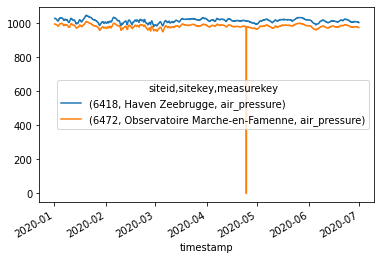

In [23]:
dp.loc[:,pd.IndexSlice[:,:,"air_pressure"]].plot()